# Отчёт о проделанной работе

## Введение

**Задача:** Прогнозирование продаж товаров современными методами прогнозирования временных рядов

## Что сделано:

1. Реализован класс, позволяющий:
    - Предобработать данные в удобный вид
    - Собрать фичи
    - Обучить и получить предсказания от следующих моделей:
        - CatBoost
    - Оценить с помощью таблиц и графиков качество прогноза, в том числе:
        - Метрики ошибки прогнозирования
        - Качество остатков (стационарность, автокорреляции и др.)

2. Написан отчёт в формате Jupiter-ноутбука представляющий:
    - Общие сведения о проделанной работе
    - Описание методов модулей класса-решения
    - Демонстрация работы класса, включающая:
        - Препроцессинг
        - Обучение на 3 периода (7д, 30д, 90д) моделей, в том числе:
            - CatBoost
        - Визульная демонстрация предсказаний моделей

## Ответы на вопросы:

1. Какие методы предобработки данных вы использовали? Почему пробовали именно их?
Предобработкой было только замещение нулей и парсинг кат-фич (этого можно было не делать т.к. использовался catboost). В качестве дополнительных фич использовались данные ряда с лагом и скользящие средние для избежания утечек. (все данные брались после паддинга равного максимальному периоду прогнощирования в этом случае это 90)
2. Какие модели пробовали? Почему пробовали именно их?
В качестве реализации градиентного бустинга я выбрал CatBoost, т. к. он наиболее современный, быстрый и выполняет большую часть предобработки самостоятельно.
3. Как вы проверяете качество модели? На каких данных? Какие метрики используете? Чем обусловлен выбор именно этих метрик?
  - Дата сет был разбит на train и test с самого начала во избежание лаков, так же т.к. для прогноза на каждый из периодов используется одни и те же модели, в test отрезан сразу на максимальный из периодов.
  - Для оценки используется MAES, т. к. много нулевых данных и значения MAPE часто будут неопределяться, даже WAPE иногда Nan на первых товарах.
  - При обучении использовалось RMSE.
  - Качество модели оценивается как совокупность качества остатков (стационарность, гомоскедатичность, нормальность и тп) и метрик (mean, median, 95per и тп). Эти данные можно посмотреть в ./results/ или вывести из модели в конце отчёта.

## О решении

### Описание модулей 

#### solution.preprocessor

feature_engineering_lag - добавляет фичи на основе предыдущих значений ряда (лаги и скользящие средние)
feature_engineering_lag_store - feature_engineering_lag по всему магазину

#### solution.models

CatBoost - позволяет обучать модель и делать предикты.

## Демонстрация работы класса

### Импорты

In [1]:
import warnings
import pandas as pd
from solution.solution_gb import SolutionGB
warnings.filterwarnings("ignore")

### Глобальные переменные

In [2]:
CALENDAR = pd.read_csv('./source/shop_sales_dates.csv')
DATA = pd.read_csv('./source/shop_sales.csv')
PRICES = pd.read_csv('./source/shop_sales_prices.csv')
STORES = sorted(DATA['store_id'].unique())

PERIODS = {"week": 7, "month": 30, "quarter": 90}

ROW = 5
COLUMN = 3

FEATURE_ENGINEERING_LAGS_OPTIONS = {
    "lag_count": 7,
    "seasonal_lag": 7,
    "seasonal_lag_count": 10,
    "mean_sizes": [7, 30],
}

SOLUTION = SolutionGB(ROW, COLUMN, PERIODS)


### Препроцессинг (собираем фичи)

In [3]:
STORE = STORES[0]
SOLUTION.load(STORE, DATA, CALENDAR, PRICES)
SOLUTION.feature_engineering_lags(FEATURE_ENGINEERING_LAGS_OPTIONS)
SOLUTION.group_by("abs_day")

In [4]:
SOLUTION.working[SOLUTION.items[0]].head()

item_id store_id  cnt  CASHBACK_STORE_1  CASHBACK_STORE_2  \
abs_day                                                                  
0        STORE_1_064  STORE_1    0                 0                 0   
1        STORE_1_064  STORE_1    1                 0                 0   
2        STORE_1_064  STORE_1    0                 0                 0   
3        STORE_1_064  STORE_1    0                 0                 1   
4        STORE_1_064  STORE_1    0                 1                 1   

         CASHBACK_STORE_3  sell_price  EVENT_VeteransDay  EVENT_NBAFinalsEnd  \
abs_day                                                                        
0                       0        2.54                  0                   0   
1                       0        2.54                  0                   0   
2                       0        2.54                  0                   0   
3                       1        2.54                  0                   0   
4                       0        2.54                  0                   0   

         EVENT_LaborDay  ...  LAG_SEASONAL_3  LAG_SEASONAL_4  LAG_SEASONAL_5  \
abs_day                  ...                                                   
0                     0  ...             0.0             0.0             0.0   
1                     0  ...             0.0             0.0             0.0   
2                     0  ...             0.0             0.0             0.0   
3                     0  ...             0.0             0.0             0.0   
4                     0  ...             0.0             0.0             0.0   

         LAG_SEASONAL_6  LAG_SEASONAL_7  LAG_SEASONAL_8  LAG_SEASONAL_9  \
abs_day                                                                   
0                   0.0             0.0             0.0             0.0   
1                   0.0             0.0             0.0             0.0   
2                   0.0             0.0             0.0             0.0   
3                   0.0             0.0             0.0             0.0   
4                   0.0             0.0             0.0             0.0   

         LAG_SEASONAL_10  ROLLING_MEAN_7_LAG  ROLLING_MEAN_30_LAG  
abs_day                                                            
0                    0.0                 0.0                  0.0  
1                    0.0                 0.0                  0.0  
2                    0.0                 0.0                  0.0  
3                    0.0                 0.0                  0.0  
4                    0.0                 0.0                  0.0  

[5 rows x 67 columns]

In [5]:
print(SOLUTION.working[SOLUTION.items[0]].columns)

Index(['item_id', 'store_id', 'cnt', 'CASHBACK_STORE_1', 'CASHBACK_STORE_2',
       'CASHBACK_STORE_3', 'sell_price', 'EVENT_VeteransDay',
       'EVENT_NBAFinalsEnd', 'EVENT_LaborDay', 'EVENT_OrthodoxEaster',
       'EVENT_ValentinesDay', 'EVENT_Father's day', 'EVENT_OrthodoxChristmas',
       'EVENT_MemorialDay', 'EVENT_MartinLutherKingDay', 'EVENT_Halloween',
       'EVENT_EidAlAdha', 'EVENT_Christmas', 'EVENT_Thanksgiving',
       'EVENT_Cinco De Mayo', 'EVENT_PresidentsDay', 'EVENT_NewYear',
       'EVENT_Purim End', 'EVENT_ColumbusDay', 'EVENT_Chanukah End',
       'EVENT_StPatricksDay', 'EVENT_Mother's day', 'EVENT_LentWeek2',
       'EVENT_SuperBowl', 'EVENT_Pesach End', 'EVENT_LentStart',
       'EVENT_NBAFinalsStart', 'EVENT_IndependenceDay', 'EVENT_Eid al-Fitr',
       'EVENT_Ramadan starts', 'EVENT_Easter', 'EVENTTYPE_National',
       'EVENTTYPE_Sporting', 'EVENTTYPE_Religious', 'EVENTTYPE_Cultural',
       'WEEKDAY_Sunday', 'WEEKDAY_Tuesday', 'WEEKDAY_Monday',
       'WEE

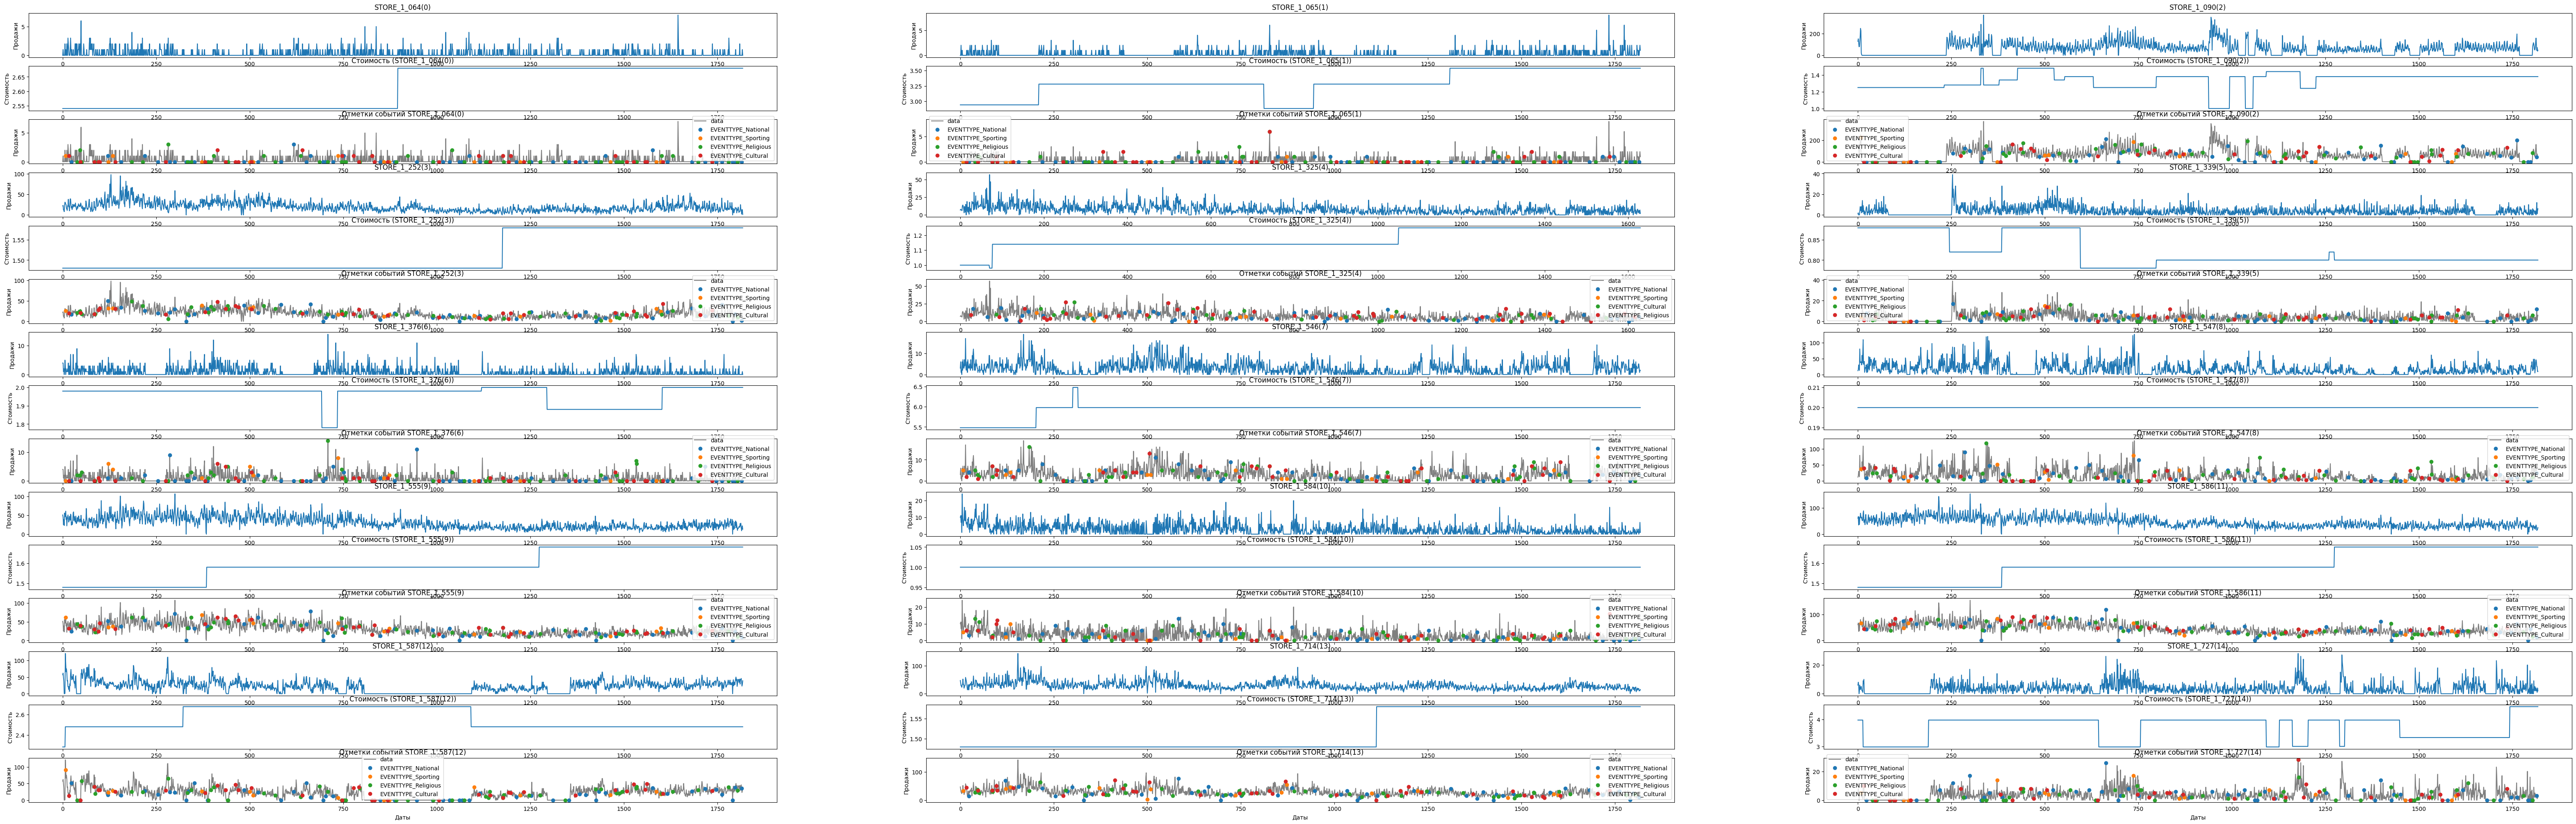

In [6]:
SOLUTION.visualize_dataset()

Разделим данные train/test для обучения на 3 сценария: 7 дней, 30 дней, 90 дней

In [7]:
SOLUTION.split_train_test()

### Анализ


#### Отчистка от нулей
По графикам рядов видно, что только для товаров под индексами 0, 1, 6, 7, 8 нули могут быть естественны, поэтому в остальных заменим нули предыдущим ненулевым значением. От всех нулей избавляться не будем, т. к. преобразование Йео-Джонсона этого не требует.

In [8]:
NATIVE_ZERO = {0, 1, 6, 7, 8}

SOLUTION.clean_zeros(NATIVE_ZERO)

STORE_1_090(2) zeroes: 451 -> 0
STORE_1_252(3) zeroes: 7 -> 0
STORE_1_325(4) zeroes: 125 -> 0
STORE_1_339(5) zeroes: 443 -> 0
STORE_1_555(9) zeroes: 5 -> 0
STORE_1_584(10) zeroes: 414 -> 0
STORE_1_586(11) zeroes: 5 -> 0
STORE_1_587(12) zeroes: 423 -> 0
STORE_1_714(13) zeroes: 6 -> 0
STORE_1_727(14) zeroes: 480 -> 0


### Предсказания

#### CatBoost

In [9]:
fields = ['CASHBACK_STORE_1', 'CASHBACK_STORE_2', 'CASHBACK_STORE_3', 'sell_price', 'EVENT_IndependenceDay', 'EVENT_Eid al-Fitr', 'EVENT_OrthodoxChristmas', 'EVENT_NBAFinalsStart', 'EVENT_Easter', "EVENT_Mother's day", 'EVENT_Cinco De Mayo', 'EVENT_ColumbusDay', 'EVENT_MartinLutherKingDay', 'EVENT_Halloween', 'EVENT_Chanukah End', 'EVENT_Pesach End', 'EVENT_Purim End', "EVENT_Father's day", 'EVENT_EidAlAdha', 'EVENT_NBAFinalsEnd', 'EVENT_Thanksgiving', 'EVENT_StPatricksDay', 'EVENT_ValentinesDay', 'EVENT_VeteransDay', 'EVENT_MemorialDay', 'EVENT_Ramadan starts', 'EVENT_SuperBowl', 'EVENT_OrthodoxEaster', 'EVENT_LentWeek2', 'EVENT_Christmas', 'EVENT_PresidentsDay', 'EVENT_LentStart', 'EVENT_LaborDay', 'EVENT_NewYear', 'EVENTTYPE_National', 'EVENTTYPE_Sporting', 'EVENTTYPE_Cultural', 'EVENTTYPE_Religious', 'WEEKDAY_Monday', 'WEEKDAY_Wednesday', 'WEEKDAY_Thursday', 'WEEKDAY_Saturday', 'WEEKDAY_Friday', 'WEEKDAY_Tuesday', 'WEEKDAY_Sunday', 'LAG_1', 'LAG_2', 'LAG_3', 'LAG_4', 'LAG_5', 'LAG_6', 'LAG_7', 'LAG_SEASONAL_1', 'LAG_SEASONAL_2', 'LAG_SEASONAL_3', 'LAG_SEASONAL_4', 'LAG_SEASONAL_5', 'LAG_SEASONAL_6', 'LAG_SEASONAL_7', 'LAG_SEASONAL_8', 'LAG_SEASONAL_9', 'LAG_SEASONAL_10', 'ROLLING_MEAN_7_LAG', 'ROLLING_MEAN_30_LAG']

In [10]:
SOLUTION.fit(fields)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.034916
0:	learn: 0.6194467	test: 0.2639788	best: 0.2639788 (0)	total: 146ms	remaining: 2m 25s
100:	learn: 0.4917214	test: 0.2157494	best: 0.2138741 (92)	total: 269ms	remaining: 2.39s
200:	learn: 0.4093587	test: 0.1994384	best: 0.1976021 (198)	total: 420ms	remaining: 1.67s
300:	learn: 0.3369536	test: 0.1912623	best: 0.1894162 (281)	total: 602ms	remaining: 1.4s
400:	learn: 0.2713024	test: 0.1875705	best: 0.1849807 (350)	total: 849ms	remaining: 1.27s
500:	learn: 0.2186725	test: 0.1807327	best: 0.1807327 (500)	total: 1.04s	remaining: 1.04s
600:	learn: 0.1818125	test: 0.1771916	best: 0.1763130 (596)	total: 1.21s	remaining: 805ms
700:	learn: 0.1520819	test: 0.1765416	best: 0.1753800 (626)	total: 1.36s	remaining: 580ms
800:	learn: 0.1257651	test: 0.1741723	best: 0.1741405 (799)	total: 1.55s	remaining: 386ms
900:	learn: 0.1065946	test: 0.1701865	best: 0.1700295 (888)	total: 1.73s	remaining: 190ms
999:	learn: 0.0883942	test: 0.1697057	best: 0.1697057 (999)	total: 1.91s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 0.6892152	test: 2.9088785	best: 2.9088785 (0)	total: 1.72ms	remaining: 1.72s
100:	learn: 0.5202566	test: 2.8885363	best: 2.8714317 (49)	total: 159ms	remaining: 1.41s
200:	learn: 0.4148363	test: 2.9007967	best: 2.8714317 (49)	total: 339ms	remaining: 1.35s
300:	learn: 0.3068848	test: 2.8864496	best: 2.8714317 (49)	total: 500ms	remaining: 1.16s
400:	learn: 0.2267004	test: 2.8883717	best: 2.8714317 (49)	total: 665ms	remaining: 993ms
500:	learn: 0.1698358	test: 2.8916639	best: 2.8714317 (49)	total: 819ms	remaining: 816ms
600:	learn: 0.1341414	test: 2.8961955	best: 2.8714317 (49)	total: 989ms	remaining: 657ms
700:	learn: 0.1095319	test: 2.8993816	best: 2.8714317 (49)	total: 1.15s	remaining: 491ms
800:	learn: 0.0889746	test: 2.8987124	best: 2.8714317 (49)	total: 1.3s	remaining: 324ms
900:	learn: 0.0739424	test: 2.8970521	best: 2.8714317 (49)	total: 1.48s	remaining: 162ms
999:	learn: 0.0629301	test: 2.8985209	best: 2.8714317 (49)	total: 1.63s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 26.7432587	test: 35.3130386	best: 35.3130386 (0)	total: 7.18ms	remaining: 7.17s
100:	learn: 12.8563864	test: 21.0119871	best: 20.9886490 (99)	total: 542ms	remaining: 4.82s
200:	learn: 8.6268670	test: 19.4796784	best: 19.4796784 (200)	total: 1.05s	remaining: 4.18s
300:	learn: 5.4057113	test: 19.4918697	best: 19.4481140 (204)	total: 1.54s	remaining: 3.58s
400:	learn: 3.5425847	test: 19.2882421	best: 19.2882421 (400)	total: 2.04s	remaining: 3.04s
500:	learn: 2.3819483	test: 19.0834992	best: 19.0610639 (492)	total: 2.58s	remaining: 2.57s
600:	learn: 1.6014138	test: 18.9430588	best: 18.9377084 (591)	total: 3.08s	remaining: 2.04s
700:	learn: 1.1229119	test: 18.8299383	best: 18.8298743 (697)	total: 3.59s	remaining: 1.53s
800:	learn: 0.7650003	test: 18.7611947	best: 18.7582949 (796)	total: 4.08s	remaining: 1.01s
900:	learn: 0.5440757	test: 18.7157385	best: 18.7143688 (896)	total: 4.56s	remaining: 501ms
999:	learn: 0.3854562	test: 18.6733087	best: 18.6674

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 8.5534231	test: 9.2670998	best: 9.2670998 (0)	total: 10.1ms	remaining: 10.1s
100:	learn: 4.8762477	test: 10.3832230	best: 9.2670998 (0)	total: 474ms	remaining: 4.22s
200:	learn: 3.2192769	test: 10.7007919	best: 9.2670998 (0)	total: 936ms	remaining: 3.72s
300:	learn: 2.0261830	test: 11.0144372	best: 9.2670998 (0)	total: 1.43s	remaining: 3.32s
400:	learn: 1.1525440	test: 11.1379395	best: 9.2670998 (0)	total: 1.97s	remaining: 2.95s
500:	learn: 0.7226761	test: 11.1841847	best: 9.2670998 (0)	total: 2.41s	remaining: 2.4s
600:	learn: 0.4487222	test: 11.1435663	best: 9.2670998 (0)	total: 2.95s	remaining: 1.96s
700:	learn: 0.2903934	test: 11.1739765	best: 9.2670998 (0)	total: 3.47s	remaining: 1.48s
800:	learn: 0.1883909	test: 11.1933450	best: 9.2670998 (0)	total: 4.12s	remaining: 1.02s
900:	learn: 0.1192444	test: 11.1998659	best: 9.2670998 (0)	total: 4.57s	remaining: 502ms
999:	learn: 0.0787455	test: 11.2019808	best: 9.2670998 (0)	total: 5.02s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 3.9822385	test: 4.2537215	best: 4.2537215 (0)	total: 2.36ms	remaining: 2.36s
100:	learn: 2.3772034	test: 4.0778866	best: 4.0778866 (100)	total: 258ms	remaining: 2.3s
200:	learn: 1.4639984	test: 4.1307379	best: 4.0437036 (110)	total: 484ms	remaining: 1.92s
300:	learn: 0.8962983	test: 3.9400586	best: 3.9399821 (299)	total: 714ms	remaining: 1.66s
400:	learn: 0.5758935	test: 3.9032667	best: 3.9002844 (399)	total: 954ms	remaining: 1.43s
500:	learn: 0.3789004	test: 3.8514663	best: 3.8509721 (497)	total: 1.18s	remaining: 1.17s
600:	learn: 0.2277938	test: 3.8311153	best: 3.8311153 (600)	total: 1.41s	remaining: 935ms
700:	learn: 0.1382843	test: 3.8379100	best: 3.8242740 (630)	total: 1.63s	remaining: 695ms
800:	learn: 0.0855458	test: 3.8421866	best: 3.8242740 (630)	total: 1.91s	remaining: 474ms
900:	learn: 0.0502057	test: 3.8445664	best: 3.8242740 (630)	total: 2.13s	remaining: 234ms
999:	learn: 0.0301391	test: 3.8449711	best: 3.8242740 (630)	total: 2.37s	r

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.9262956	test: 2.0575693	best: 2.0575693 (0)	total: 1.95ms	remaining: 1.95s
100:	learn: 1.8914171	test: 1.7355174	best: 1.7355174 (100)	total: 199ms	remaining: 1.77s
200:	learn: 1.1694538	test: 1.7482987	best: 1.7147501 (105)	total: 424ms	remaining: 1.69s
300:	learn: 0.6549390	test: 1.6963705	best: 1.6906332 (282)	total: 623ms	remaining: 1.45s
400:	learn: 0.3572686	test: 1.6386069	best: 1.6375769 (398)	total: 813ms	remaining: 1.21s
500:	learn: 0.1964041	test: 1.6063359	best: 1.6058990 (499)	total: 1.04s	remaining: 1.03s
600:	learn: 0.1126102	test: 1.5812158	best: 1.5811057 (592)	total: 1.24s	remaining: 822ms
700:	learn: 0.0658586	test: 1.5724180	best: 1.5717203 (696)	total: 1.48s	remaining: 630ms
800:	learn: 0.0382950	test: 1.5653720	best: 1.5651406 (790)	total: 1.68s	remaining: 416ms
900:	learn: 0.0231451	test: 1.5642080	best: 1.5639675 (883)	total: 1.87s	remaining: 206ms
999:	learn: 0.0137643	test: 1.5619067	best: 1.5618093 (978)	total: 2.08s	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 1.1808164	test: 0.5977405	best: 0.5977405 (0)	total: 1.77ms	remaining: 1.77s
100:	learn: 0.9559985	test: 0.4942835	best: 0.4942835 (100)	total: 168ms	remaining: 1.5s
200:	learn: 0.7363732	test: 0.5052938	best: 0.4942835 (100)	total: 337ms	remaining: 1.34s
300:	learn: 0.5347567	test: 0.4671769	best: 0.4648701 (279)	total: 509ms	remaining: 1.18s
400:	learn: 0.3829852	test: 0.4516445	best: 0.4493098 (390)	total: 658ms	remaining: 983ms
500:	learn: 0.2782739	test: 0.4523020	best: 0.4444272 (486)	total: 800ms	remaining: 797ms
600:	learn: 0.2137588	test: 0.4717002	best: 0.4444272 (486)	total: 969ms	remaining: 643ms
700:	learn: 0.1634835	test: 0.4814959	best: 0.4444272 (486)	total: 1.13s	remaining: 481ms
800:	learn: 0.1279032	test: 0.4926945	best: 0.4444272 (486)	total: 1.28s	remaining: 319ms
900:	learn: 0.0991723	test: 0.4946990	best: 0.4444272 (486)	total: 1.45s	remaining: 159ms
999:	learn: 0.0762646	test: 0.4978564	best: 0.4444272 (486)	total: 1.6s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.6356555	test: 2.4423444	best: 2.4423444 (0)	total: 2.57ms	remaining: 2.57s
100:	learn: 1.5574033	test: 2.5256157	best: 2.4423444 (0)	total: 242ms	remaining: 2.16s
200:	learn: 1.0301293	test: 2.5299081	best: 2.4423444 (0)	total: 466ms	remaining: 1.85s
300:	learn: 0.6494142	test: 2.5793624	best: 2.4423444 (0)	total: 689ms	remaining: 1.6s
400:	learn: 0.4405651	test: 2.6047073	best: 2.4423444 (0)	total: 913ms	remaining: 1.36s
500:	learn: 0.2969749	test: 2.5849488	best: 2.4423444 (0)	total: 1.16s	remaining: 1.16s
600:	learn: 0.2046207	test: 2.5879241	best: 2.4423444 (0)	total: 1.4s	remaining: 927ms
700:	learn: 0.1457256	test: 2.5851329	best: 2.4423444 (0)	total: 1.64s	remaining: 698ms
800:	learn: 0.1033305	test: 2.5850590	best: 2.4423444 (0)	total: 1.85s	remaining: 461ms
900:	learn: 0.0747192	test: 2.5842901	best: 2.4423444 (0)	total: 2.09s	remaining: 230ms
999:	learn: 0.0537763	test: 2.5838848	best: 2.4423444 (0)	total: 2.38s	remaining: 0us

bestTe

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 11.2490104	test: 8.2897468	best: 8.2897468 (0)	total: 3.32ms	remaining: 3.31s
100:	learn: 6.5985338	test: 7.0981517	best: 6.8281381 (75)	total: 337ms	remaining: 3s
200:	learn: 4.8381629	test: 7.0354029	best: 6.8281381 (75)	total: 660ms	remaining: 2.62s
300:	learn: 3.3504404	test: 7.3979387	best: 6.8281381 (75)	total: 978ms	remaining: 2.27s
400:	learn: 2.3129250	test: 7.5449408	best: 6.8281381 (75)	total: 1.31s	remaining: 1.96s
500:	learn: 1.6084579	test: 7.6948660	best: 6.8281381 (75)	total: 1.65s	remaining: 1.64s
600:	learn: 1.0986043	test: 7.7896238	best: 6.8281381 (75)	total: 1.98s	remaining: 1.31s
700:	learn: 0.7449230	test: 7.8065232	best: 6.8281381 (75)	total: 2.29s	remaining: 979ms
800:	learn: 0.5117517	test: 7.8168760	best: 6.8281381 (75)	total: 2.63s	remaining: 653ms
900:	learn: 0.3584854	test: 7.8187163	best: 6.8281381 (75)	total: 2.96s	remaining: 326ms
999:	learn: 0.2500518	test: 7.8182269	best: 6.8281381 (75)	total: 3.3s	remaining: 0u

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 7.1175733	test: 7.8374643	best: 7.8374643 (0)	total: 3.77ms	remaining: 3.77s
100:	learn: 4.3329291	test: 6.6630446	best: 6.6179755 (97)	total: 278ms	remaining: 2.48s
200:	learn: 3.0329248	test: 6.5129513	best: 6.4396381 (151)	total: 567ms	remaining: 2.25s
300:	learn: 1.8420820	test: 6.5258551	best: 6.4040432 (233)	total: 839ms	remaining: 1.95s
400:	learn: 1.1511050	test: 6.5165545	best: 6.4040432 (233)	total: 1.15s	remaining: 1.72s
500:	learn: 0.7370800	test: 6.4864251	best: 6.4040432 (233)	total: 1.44s	remaining: 1.43s
600:	learn: 0.4680415	test: 6.4645471	best: 6.4040432 (233)	total: 1.73s	remaining: 1.15s
700:	learn: 0.3006254	test: 6.4611260	best: 6.4040432 (233)	total: 2.04s	remaining: 868ms
800:	learn: 0.2028267	test: 6.4490517	best: 6.4040432 (233)	total: 2.32s	remaining: 577ms
900:	learn: 0.1363992	test: 6.4454145	best: 6.4040432 (233)	total: 2.61s	remaining: 287ms
999:	learn: 0.0917163	test: 6.4383017	best: 6.4040432 (233)	total: 2.9s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 1.8978109	test: 2.4669581	best: 2.4669581 (0)	total: 2.04ms	remaining: 2.03s
100:	learn: 1.1934744	test: 2.3285140	best: 2.3112034 (94)	total: 188ms	remaining: 1.68s
200:	learn: 0.8088294	test: 2.4064446	best: 2.3112034 (94)	total: 374ms	remaining: 1.48s
300:	learn: 0.5430380	test: 2.3897007	best: 2.3112034 (94)	total: 561ms	remaining: 1.3s
400:	learn: 0.3303079	test: 2.3970456	best: 2.3112034 (94)	total: 768ms	remaining: 1.15s
500:	learn: 0.1902365	test: 2.3737000	best: 2.3112034 (94)	total: 964ms	remaining: 960ms
600:	learn: 0.1201055	test: 2.3650723	best: 2.3112034 (94)	total: 1.19s	remaining: 793ms
700:	learn: 0.0719487	test: 2.3660362	best: 2.3112034 (94)	total: 1.38s	remaining: 589ms
800:	learn: 0.0467217	test: 2.3683749	best: 2.3112034 (94)	total: 1.58s	remaining: 392ms
900:	learn: 0.0323866	test: 2.3683031	best: 2.3112034 (94)	total: 1.76s	remaining: 194ms
999:	learn: 0.0207290	test: 2.3702642	best: 2.3112034 (94)	total: 2.1s	remaining: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 10.6515682	test: 9.7255035	best: 9.7255035 (0)	total: 4.99ms	remaining: 4.98s
100:	learn: 6.3645118	test: 8.4952161	best: 8.4342192 (81)	total: 463ms	remaining: 4.12s
200:	learn: 4.4697918	test: 8.6270281	best: 8.4318138 (158)	total: 821ms	remaining: 3.26s
300:	learn: 2.8372004	test: 9.0150501	best: 8.4318138 (158)	total: 1.2s	remaining: 2.79s
400:	learn: 1.8470922	test: 9.1244484	best: 8.4318138 (158)	total: 1.6s	remaining: 2.39s
500:	learn: 1.0884117	test: 9.1892275	best: 8.4318138 (158)	total: 2.04s	remaining: 2.03s
600:	learn: 0.6755123	test: 9.2245956	best: 8.4318138 (158)	total: 2.39s	remaining: 1.59s
700:	learn: 0.4297695	test: 9.2584505	best: 8.4318138 (158)	total: 2.76s	remaining: 1.18s
800:	learn: 0.2761361	test: 9.2674345	best: 8.4318138 (158)	total: 3.12s	remaining: 776ms
900:	learn: 0.1896848	test: 9.2708330	best: 8.4318138 (158)	total: 3.48s	remaining: 383ms
999:	learn: 0.1262005	test: 9.2826223	best: 8.4318138 (158)	total: 3.84s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 9.9869533	test: 6.8674574	best: 6.8674574 (0)	total: 6.87ms	remaining: 6.86s
100:	learn: 5.1765931	test: 2.6211590	best: 2.6211590 (100)	total: 394ms	remaining: 3.51s
200:	learn: 3.1033029	test: 2.5143019	best: 2.4497676 (115)	total: 777ms	remaining: 3.09s
300:	learn: 2.1557794	test: 2.6230029	best: 2.4497676 (115)	total: 1.15s	remaining: 2.68s
400:	learn: 1.5119514	test: 2.5426506	best: 2.4497676 (115)	total: 1.55s	remaining: 2.32s
500:	learn: 1.0574978	test: 2.5161527	best: 2.4497676 (115)	total: 1.93s	remaining: 1.92s
600:	learn: 0.6721162	test: 2.4822540	best: 2.4497676 (115)	total: 2.28s	remaining: 1.52s
700:	learn: 0.4376434	test: 2.4926418	best: 2.4497676 (115)	total: 2.67s	remaining: 1.14s
800:	learn: 0.2959409	test: 2.4899933	best: 2.4497676 (115)	total: 3.1s	remaining: 771ms
900:	learn: 0.2100753	test: 2.4921611	best: 2.4497676 (115)	total: 3.54s	remaining: 389ms
999:	learn: 0.1471133	test: 2.4889765	best: 2.4497676 (115)	total: 3.93s	r

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 8.5313846	test: 7.0376938	best: 7.0376938 (0)	total: 3.2ms	remaining: 3.2s
100:	learn: 5.3484259	test: 6.8989371	best: 6.8989371 (100)	total: 337ms	remaining: 3s
200:	learn: 3.7996117	test: 6.7916822	best: 6.6594322 (164)	total: 666ms	remaining: 2.65s
300:	learn: 2.6320184	test: 7.2717229	best: 6.6594322 (164)	total: 1.02s	remaining: 2.37s
400:	learn: 1.7134304	test: 7.4032551	best: 6.6594322 (164)	total: 1.34s	remaining: 2.01s
500:	learn: 1.0642866	test: 7.4609159	best: 6.6594322 (164)	total: 1.68s	remaining: 1.67s
600:	learn: 0.6881922	test: 7.4722863	best: 6.6594322 (164)	total: 2.03s	remaining: 1.35s
700:	learn: 0.4448848	test: 7.4693126	best: 6.6594322 (164)	total: 2.4s	remaining: 1.02s
800:	learn: 0.2756740	test: 7.4942704	best: 6.6594322 (164)	total: 2.74s	remaining: 681ms
900:	learn: 0.1772664	test: 7.4930713	best: 6.6594322 (164)	total: 3.08s	remaining: 339ms
999:	learn: 0.1182967	test: 7.4904727	best: 6.6594322 (164)	total: 3.48s	remain

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 3.7730583	test: 2.8550598	best: 2.8550598 (0)	total: 2.55ms	remaining: 2.55s
100:	learn: 2.3795245	test: 1.9678482	best: 1.9678482 (100)	total: 287ms	remaining: 2.55s
200:	learn: 1.5053036	test: 1.9598168	best: 1.9295869 (188)	total: 539ms	remaining: 2.14s
300:	learn: 0.9742700	test: 2.0067945	best: 1.9295869 (188)	total: 791ms	remaining: 1.84s
400:	learn: 0.6362666	test: 1.9794583	best: 1.9295869 (188)	total: 1.07s	remaining: 1.6s
500:	learn: 0.4316436	test: 1.9948204	best: 1.9295869 (188)	total: 1.36s	remaining: 1.35s
600:	learn: 0.2988906	test: 2.0125411	best: 1.9295869 (188)	total: 1.63s	remaining: 1.08s
700:	learn: 0.2139460	test: 2.0159275	best: 1.9295869 (188)	total: 1.87s	remaining: 797ms
800:	learn: 0.1532105	test: 2.0179436	best: 1.9295869 (188)	total: 2.15s	remaining: 535ms
900:	learn: 0.1129565	test: 2.0174794	best: 1.9295869 (188)	total: 2.44s	remaining: 268ms
999:	learn: 0.0830415	test: 2.0138656	best: 1.9295869 (188)	total: 2.69s	r

In [11]:
SOLUTION.predict()

predicting catboost models ...


### Скоринг

Результаты на week: 


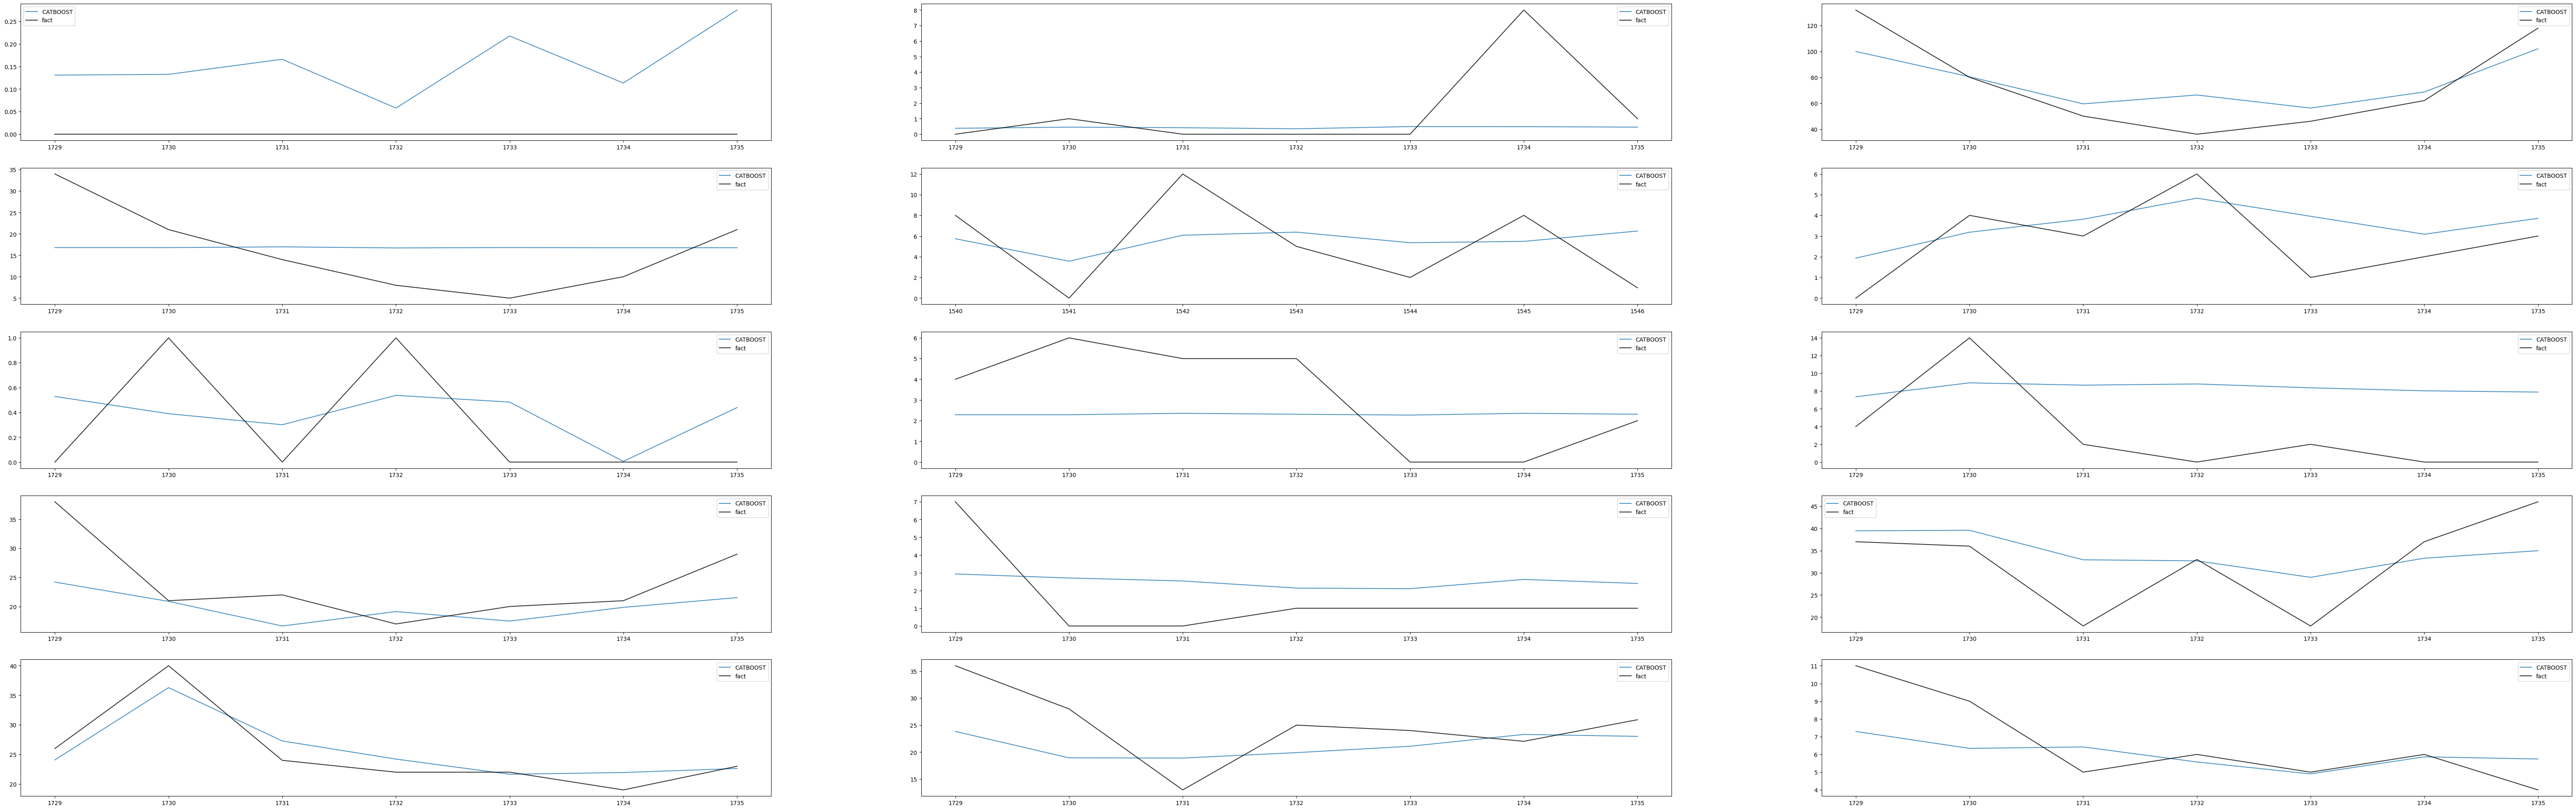

Результаты на month: 


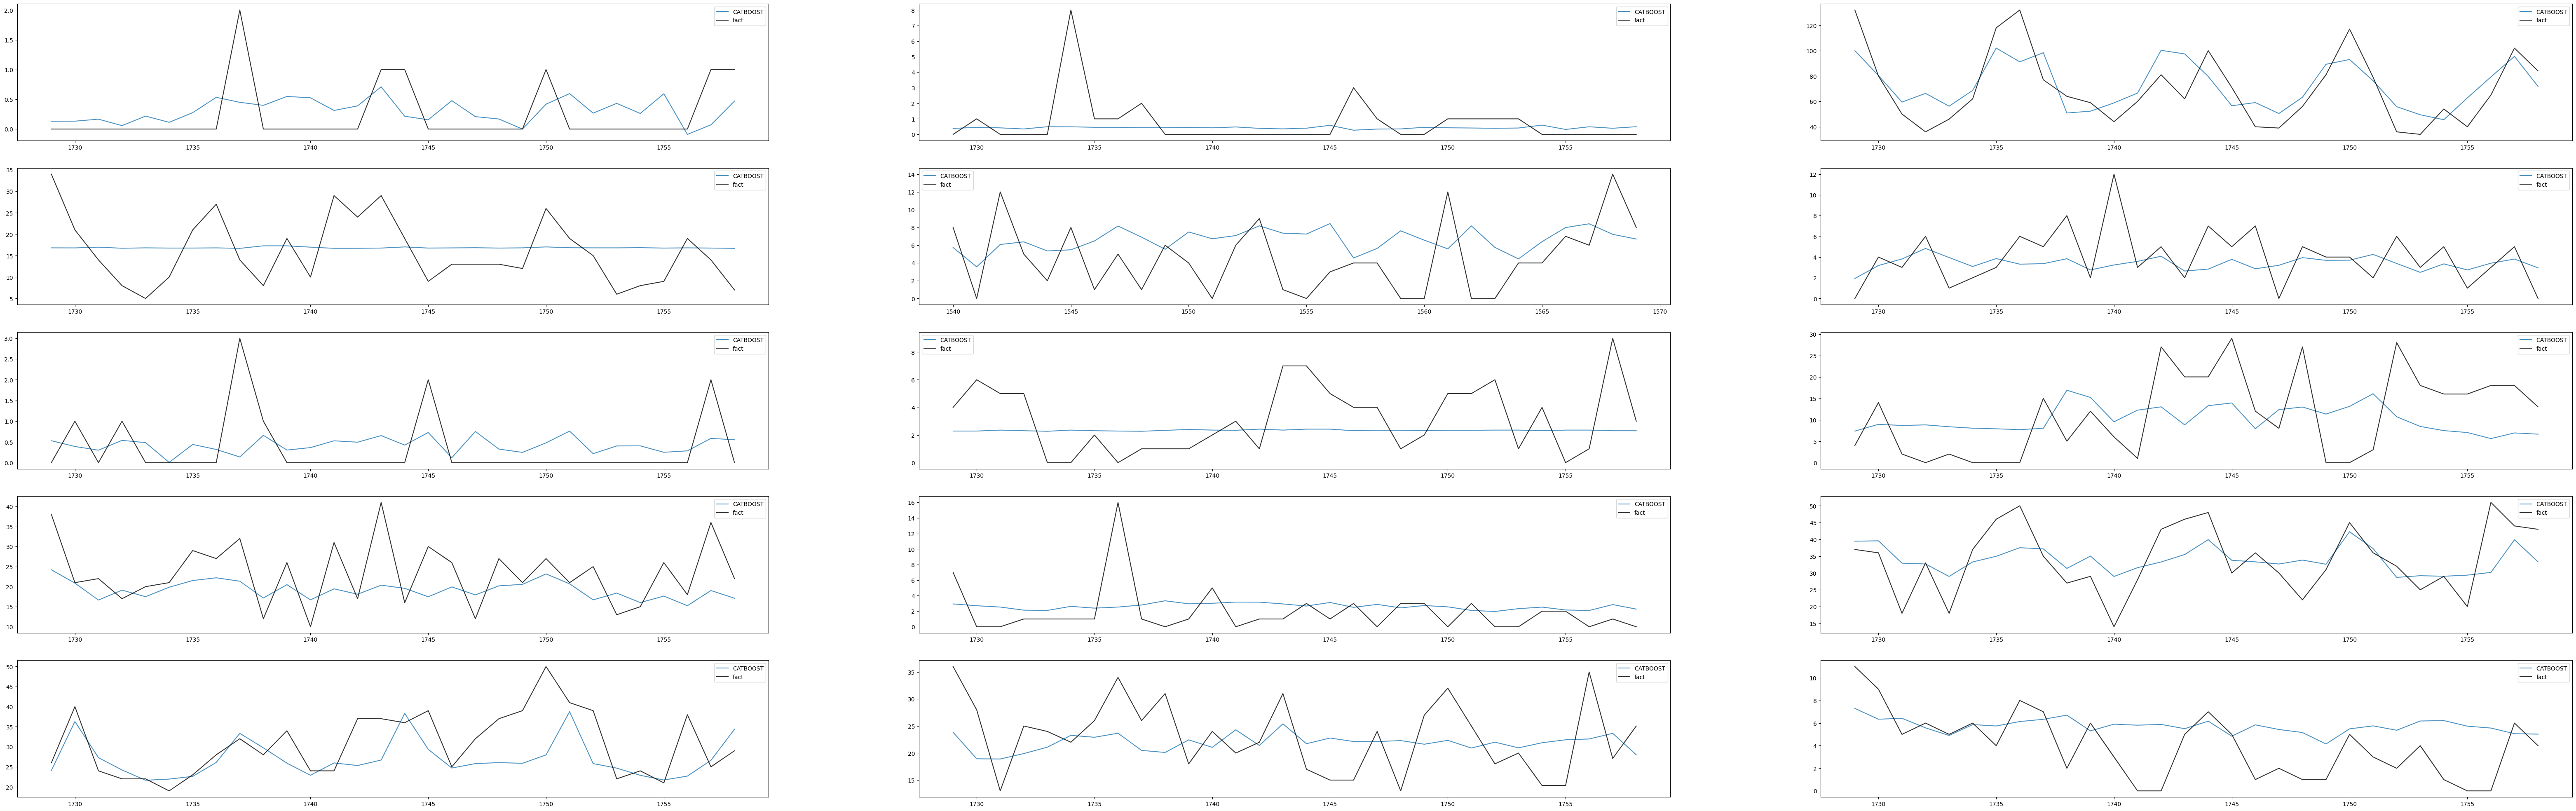

Результаты на quarter: 


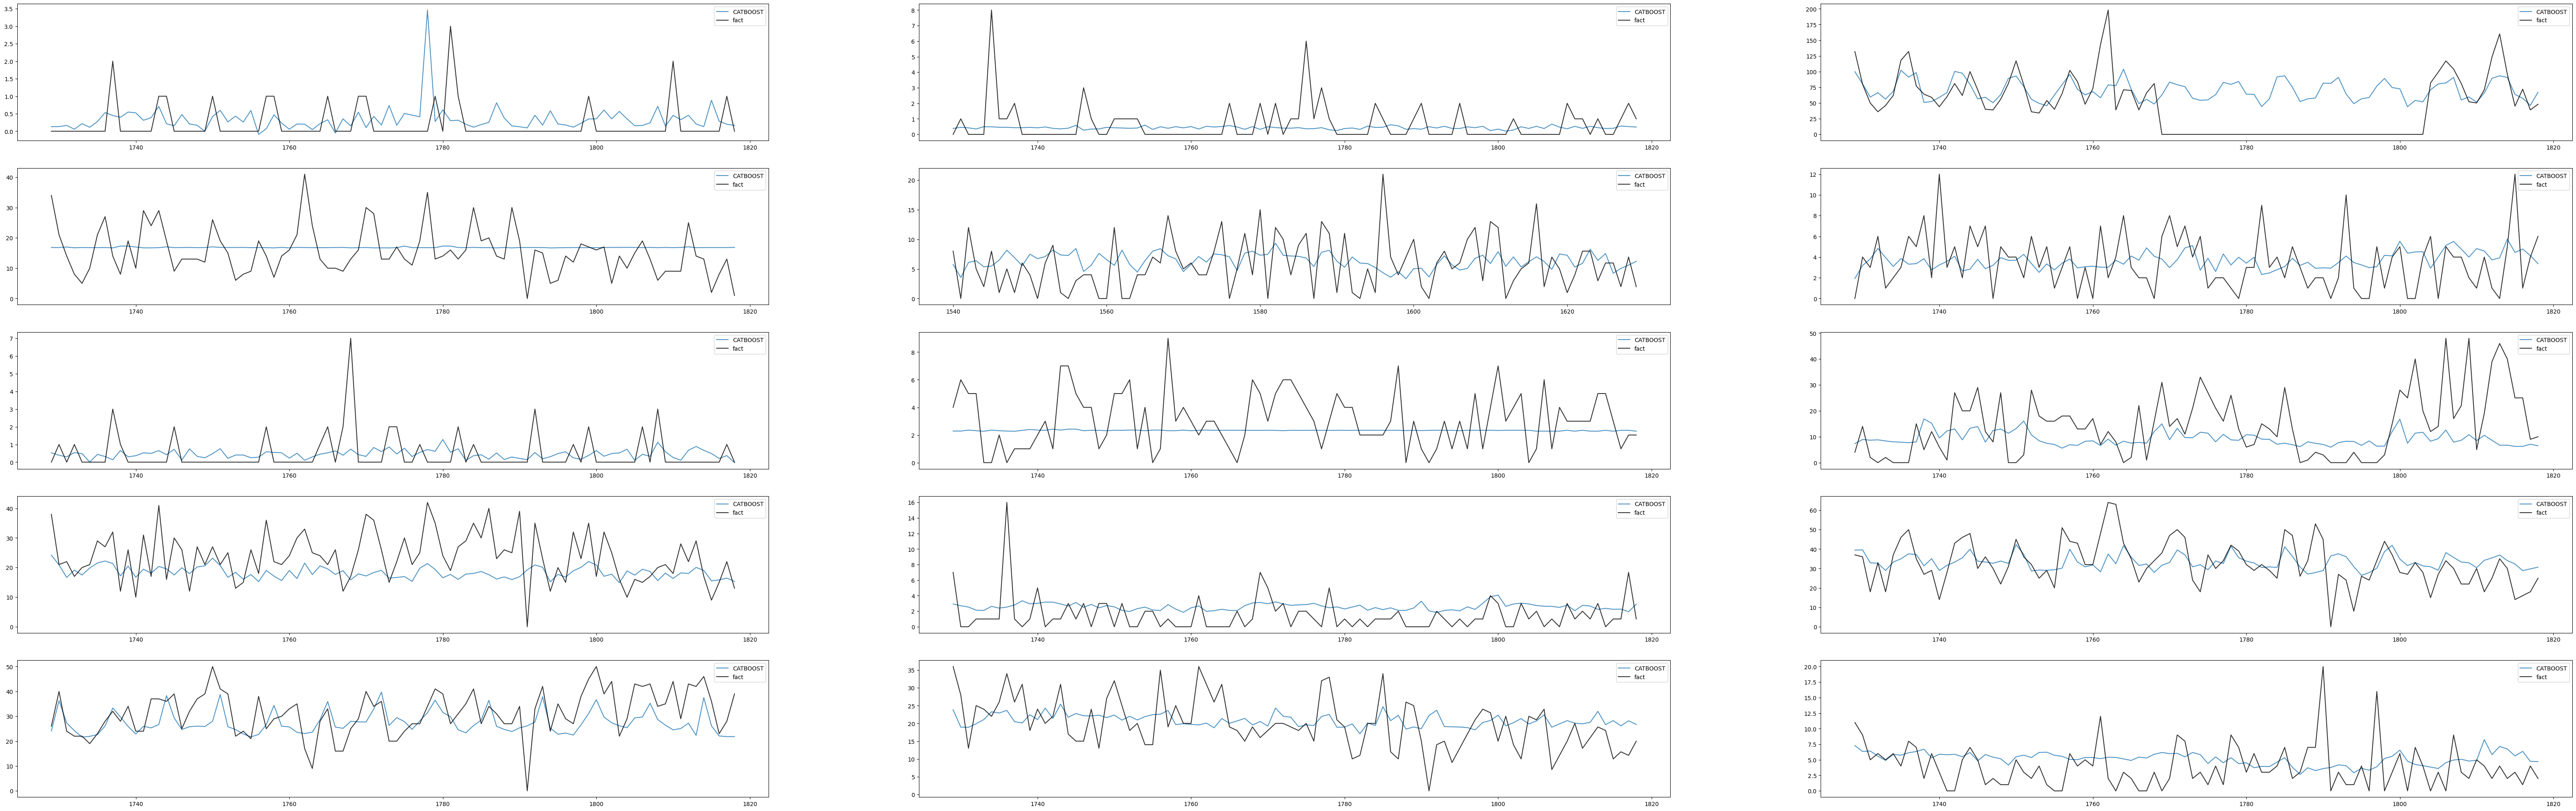

In [12]:
SOLUTION.scoring_predicts()

Выведем победителей:

In [13]:
SOLUTION.print_best()

Результаты по week:
STORE_1_064(0) best: CATBOOST (0.13263484253450308)
STORE_1_065(1) best: CATBOOST (0.4918872661275652)
STORE_1_090(2) best: CATBOOST (10.205502733257369)
STORE_1_252(3) best: CATBOOST (6.764383316040039)
STORE_1_325(4) best: CATBOOST (3.355542295783583)
STORE_1_339(5) best: CATBOOST (1.088846912801225)
STORE_1_376(6) best: CATBOOST (0.46293059018499194)
STORE_1_546(7) best: CATBOOST (2.355490920316624)
STORE_1_547(8) best: CATBOOST (6.669983107146688)
STORE_1_555(9) best: CATBOOST (2.506119142298978)
STORE_1_584(10) best: CATBOOST (1.625220287605924)
STORE_1_586(11) best: CATBOOST (3.718457040660695)
STORE_1_587(12) best: CATBOOST (2.2133912587111837)
STORE_1_714(13) best: CATBOOST (5.095948234662615)
STORE_1_727(14) best: CATBOOST (1.4217391795122811)
Результаты по month:
STORE_1_064(0) best: CATBOOST (0.30150865947773087)
STORE_1_065(1) best: CATBOOST (0.4907404633897948)
STORE_1_090(2) best: CATBOOST (14.34865708758213)
STORE_1_252(3) best: CATBOOST (6.8702918686

Посмотреть полный скоринг по предметы и периоду:

In [14]:
SOLUTION.scoring_results[SOLUTION.items[1]]["week"]

mean    median    quan75    quan95       std  \
CATBOOST  1.463094  0.491887  0.543485  5.421905  2.668686   

                no_stationary is_stationary no_autocorrelation  \
CATBOOST  0.1493163613003805❌          0.1✅               0.0✅   

           is_homoscedasticity          is_mean_zero             is_normality  
CATBOOST  0.36157872474323405✅  0.40095480364449143✅  0.00014190660470158955❌